## Import Modules

In [28]:
import os
import glob
import cv2
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import scipy.io as sio
from scipy import ndimage
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.optimize import curve_fit
import tifffile as tiff
import skimage.io as io
from skimage.feature import peak_local_max
import trackpy as tp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
import matplotlib
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, Image
import multiprocessing as mp
import warnings

# Configure Matplotlib animations
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128  

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Define functions

In [29]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path to a format suitable for code by replacing single backslashes with double backslashes.
    
    Parameters:
    - windows_path: str, the Windows file path
    
    Returns:
    - str, the modified file path with escaped backslashes
    """
    return windows_path.replace("\\", "\\\\")


def cluster_optical_flow(us, vs, kernel_type='gaussian', kernel_size=21, normalize=False, verbose=False):    
    """
    Applies a smoothing kernel to optical flow fields to cluster motion patterns.
    
    Parameters:
    - us: list of 2D arrays, horizontal optical flow components
    - vs: list of 2D arrays, vertical optical flow components
    - kernel_type: str, type of kernel to use ('gaussian' or 'uniform')
    - kernel_size: int, size of the kernel (must be an odd integer)
    - normalize: bool, if True, normalizes the optical flow vectors before convolution
    - verbose: bool, if True, enables progress tracking via tqdm
    
    Returns:
    - list of 2D arrays representing clustered optical flow fields
    """
    # Create a smoothing kernel
    N = kernel_size
    if kernel_type == 'gaussian':
        gaussian_window = sp.signal.windows.gaussian(N, std=5, sym=True).reshape(-1, 1)
        gaussian_kernel = gaussian_window @ gaussian_window.T
        gaussian_kernel[N // 2, N // 2] = 0  # Set center value to 0
        kernel_gpu = cp.asarray(gaussian_kernel)  # Convert to CuPy for GPU processing
    elif kernel_type == 'uniform':
        kernel_gpu = cp.ones((N, N), dtype=cp.float32)
        kernel_gpu[N // 2, N // 2] = 0
        kernel_gpu /= cp.sum(kernel_gpu)  # Normalize kernel

    # Convolve optical flow fields with the kernel
    cluster = []
    for u, v in tqdm(zip(us, vs), disable=(not verbose)):
        u_gpu, v_gpu = cp.asarray(u), cp.asarray(v)

        if normalize:
            norm = cp.sqrt(u_gpu**2 + v_gpu**2)
            norm[norm == 0] = 1.0  # Avoid division by zero
            u_gpu /= norm
            v_gpu /= norm
            u_gpu[cp.isnan(u_gpu)] = 0
            v_gpu[cp.isnan(v_gpu)] = 0

        # Apply convolution using CuPy
        u_gpu *= cpx_ndimage.convolve(u_gpu, kernel_gpu, mode='constant', cval=0.0)
        v_gpu *= cpx_ndimage.convolve(v_gpu, kernel_gpu, mode='constant', cval=0.0)

        # Move result back to CPU and store in list
        cluster.append(u_gpu.get() + v_gpu.get())

    return cluster


def remove_static_tracks(df, movement_threshold=1.0):
    """
    Removes static tracks based on total displacement of particles.
    
    Parameters:
    - df: pandas DataFrame, contains particle tracking data with 'x', 'y', and 'particle' columns
    - movement_threshold: float, minimum total displacement required for a track to be retained
    
    Returns:
    - DataFrame containing only tracks with displacement above the threshold
    """
    valid_particles = []

    # Group by 'particle' to process each track separately
    for particle_id, track in df.groupby('particle'):
        x_diff, y_diff = track['x'].diff().dropna(), track['y'].diff().dropna()
        displacement = np.sqrt(x_diff**2 + y_diff**2)  # Compute Euclidean distance
        total_displacement = displacement.sum()

        if total_displacement > movement_threshold:
            valid_particles.append(particle_id)

    return df[df['particle'].isin(valid_particles)]


def filter_tracks(df, movement_threshold=1.0):
    """
    Filters out tracks that are either discontinuous (contain NaN values) or static.
    
    Parameters:
    - df: pandas DataFrame, contains particle tracking data with 'x', 'y', and 'frame' columns
    - movement_threshold: float, minimum total displacement required for a track to be retained
    
    Returns:
    - DataFrame with only valid tracks
    """
    df = df.dropna(subset=['x', 'y', 'frame'])  # Remove incomplete tracks
    df_filtered = remove_static_tracks(df, movement_threshold)  # Remove static tracks
    return df_filtered


## Clustering of Optical Flow vectors

In [30]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron1_media')
file_name = 'dish2_control_neuron1_media_jttr_blch_corr.tiff'
resolution = 2.7778   # Pixels per micrometer
frame_interval = 2.00137  # Seconds per frame

# Load raw (or jitter + bleach-corrected ideally) image stack
image_path = data_folder + '\\' + file_name
img = tiff.imread(image_path)

# Load optical flow files
of_path = data_folder + '\\Op_flow'
of_list = natsorted(os.listdir(of_path))

# Load neural mask from MATLAB file (assuming it's already there)
mask = sio.loadmat(data_folder + '\\neural_mask.mat')['neural_mask']
mask = mask.astype(float)  # Convert the mask to float
mask[mask == 0] = np.NaN  # Set zero values to NaN

# Determine the number of frames in the optical flow data
n_frames = len(of_list)  # Number of time-frames in the movie

# Get the spatial dimensions of optical flow field from the first file
y_span = np.shape(sio.loadmat(of_path + '\\0.mat')['vy'])[0]
x_span = np.shape(sio.loadmat(of_path + '\\0.mat')['vy'])[1]

# Initialize arrays to store optical flow components
vy_all = np.zeros((n_frames, y_span, x_span))
vx_all = np.zeros((n_frames, y_span, x_span))

# Load optical flow data for all frames
for i in tqdm(range(len(of_list))):
    matr = sio.loadmat(of_path + '\\' + of_list[i])  # Load MATLAB file
    vy_all[i, :, :] = matr['vy']  # Extract vertical component
    vx_all[i, :, :] = matr['vx']  # Extract horizontal component

# Apply clustering to optical flow field
cluster = cluster_optical_flow(vx_all, vy_all, kernel_type='gaussian', kernel_size=11, normalize=False, verbose=False)


100%|██████████| 125/125 [00:00<00:00, 286.16it/s]


## Tracking the clusters over time and print the number of trajectories in the last frame

In [31]:
## Parameters for particle detection
diameter = 5  # Approximate size of the particle in pixels
minmass = 1.0  # Minimum integrated brightness (mass) of a particle to be considered
search_range = 5  # Maximum displacement between frames in pixels for linking trajectories

# A list to store particle locations for each frame
particle_positions = []

# Loop through each 2D frame to detect particles
for t in tqdm(range(n_frames)):
    """
    Detects and stores particle positions for each frame.

    Steps:
    - Extracts a 2D frame from the clustered optical flow data.
    - Applies the mask to ignore background regions.
    - Uses Trackpy to locate particles with sub-pixel accuracy.
    - Adds frame number to detected particles.
    """
    frame = np.nan_to_num(cluster[t] * mask, nan=0)  # Get the 2D frame from the 3D stack (apply mask)
    
    # Detect particles with sub-pixel accuracy
    particles = tp.locate(frame, diameter=diameter, minmass=minmass, separation=15)
    
    # Add the frame number to each detected particle's data
    particles['frame'] = t
    
    # Store the detected particles
    particle_positions.append(particles)

# Combine all particle positions across frames into a single DataFrame
peaks_df = pd.concat(particle_positions)

# Use Trackpy to link the particles over time
tp_trajectories = tp.link(peaks_df, search_range=search_range, memory=1)

# Now tp_trajectories contains sub-pixel accurate positions and is linked over time
# print(tp_trajectories.head())


Frame 124: 89 trajectories present.


## Post-processing of the tracks:
### Step-i) Prunning out small tracks: We need a duration of atleast 10 timeframes
### Step-ii) Getting rid of the static and discontinuous tracks

#### Finally making sure the filter worked

In [32]:
# Filter out tracks with less than 10 frames
tp_trajectories_pruned = tp.filter_stubs(tp_trajectories, 10)  
"""
Removes short-lived tracks.

Tracks that appear in fewer than 10 frames are removed from the dataset to 
ensure that only meaningful particle trajectories are retained.
"""

movement_threshold = 3.0  # Adjust this threshold as needed
tp_trajectories_filtered = filter_tracks(tp_trajectories_pruned, movement_threshold)
"""
Filters tracks based on movement threshold.

Parameters:
- movement_threshold (float): Minimum displacement required to keep a track.
Tracks that do not move significantly over time are considered noise and are removed.
"""

# Calculate the duration of each track
track_duration = tp_trajectories_filtered.groupby('particle')['frame'].apply(
    lambda x: x.max() - x.min() + 1
).reset_index(name='track_duration')
"""
Computes the duration of each track.

For each unique particle, the number of frames it appears in is calculated 
as (last frame - first frame + 1).
"""

# Identify and display tracks with less than 10 frames
"""
Filters and prints tracks with a duration of fewer than 10 frames.
These tracks may be considered too short for meaningful analysis.
"""

short_tracks = track_duration[track_duration['track_duration'] < 10]  
print(short_tracks)  # Display tracks with less than 10 frames



Empty DataFrame
Columns: [particle, track_duration]
Index: []


## Visualize and save (if needed) the tracks

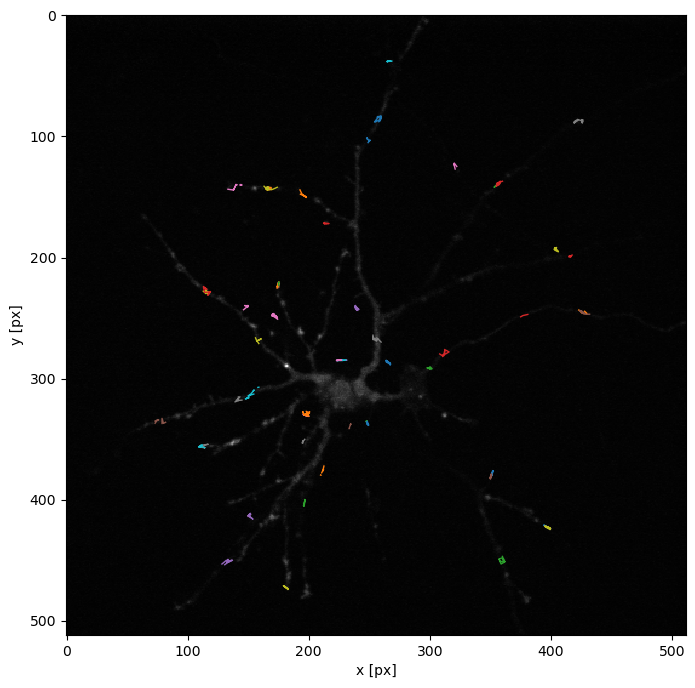

In [33]:
# Visualize the trajectories
fig, ax = plt.subplots(figsize = (8,12))  # Create a figure and axes
tp.plot_traj(tp_trajectories_filtered,superimpose=img[0],ax=ax)  # Pass the axes to the plot_traj function

ax.set_aspect('equal')  # Set equal axis scaling to ensure equal aspect ratio
plt.show()

# Save as SVG with highest resolution
# fig.savefig(data_folder+'\\filtered_tracks.png', format='png', bbox_inches='tight', dpi = 600)

## Track properties calculation (speed, length, duration etc.)

In [34]:
def calculate_track_metrics(tp_trajectories_filtered, resolution, frame_interval):
    """
    Calculate and store instantaneous shifts, displacements, velocities, total track properties, 
    and other metrics for each particle's trajectory.

    Parameters:
    - tp_trajectories_filtered (pandas DataFrame): Particle tracking data with 'x', 'y', 'frame', and 'particle' columns.
    - resolution (float): Spatial resolution to convert units as required (e.g., pixels to microns).
    - frame_interval (float): Time interval between frames to calculate velocities and track duration.

    Returns:
    - tp_trajectories_filtered (pandas DataFrame): Input DataFrame with added columns:
        - 'x_shift': x-direction shift per frame for each particle.
        - 'y_shift': y-direction shift per frame for each particle.
        - 'frame_shift': Number of frames between positions in the trajectory.
        - 'displacement': Frame-to-frame displacement (Euclidean distance) in pixels.
        - 'inst_velocity': Instantaneous velocity per frame (#px./frame) for each particle.
    - track_properties (pandas DataFrame): Aggregated track-level metrics per particle, including:
        - 'track_length': Total track length, i.e., cumulative distance traveled by each particle (microns).
        - 'track_duration': Total duration of each particle's trajectory (seconds).
        - 'distance': Net displacement from initial to final position (microns).
        - 'avg_velocity': Average net velocity (net displacement divided by total time, in microns/min).
        - 'inst_velocity': Average instantaneous velocity (total track length divided by total time, in microns/min).
        - 'sinuosity': Measure of track straightness (track length divided by net displacement).
    """

    # Calculate Instantaneous Shifts (x, y, and frame)
    tp_trajectories_filtered['x_shift'] = (tp_trajectories_filtered.groupby('particle')['x'].diff().fillna(0)) 
    tp_trajectories_filtered['y_shift'] = (tp_trajectories_filtered.groupby('particle')['y'].diff().fillna(0)) 
    tp_trajectories_filtered['frame_shift']  = tp_trajectories_filtered.groupby('particle')['frame'].diff().fillna(1)
    
    # Calculate instantaneous displacement and velocity
    tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)
    tp_trajectories_filtered['inst_velocity'] = (tp_trajectories_filtered['displacement'] /
                                                 tp_trajectories_filtered['frame_shift'])
    
    # Drop NaN values from displacement and velocity
    tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'], inplace=True)


    # Calculate track-level metrics: total distance traveled (track length), track duration, distance, average velocity, and sinuosity   
    
    # Calculate track length (total distance traversed) by summing displacements for each particle
    track_properties = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index()   
    track_properties['track_length'] = track_properties['displacement'] / resolution
    
    # Dropping the 'displacement' column from the new dataframe
    track_properties = track_properties.drop(columns='displacement')
    
    # Calculate track duration (total frames converted to seconds)
    track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')
    track_duration['track_duration'] = (track_duration['track_duration']-1) * frame_interval
    
    # Merge the track_duration back into track_properties DataFrame
    track_properties = track_properties.merge(track_duration[['particle', 'track_duration']], on='particle', how='left')

    # Calculate total displacement (net distance between start and end positions)
    track_metrics = tp_trajectories_filtered.groupby('particle').agg(
        x_start=('x', 'first'),
        y_start=('y', 'first'),
        x_end=('x', 'last'),
        y_end=('y', 'last'),
        frame_start=('frame', 'first'),
        frame_end=('frame', 'last')
    ).reset_index()
    
    # Calculate total displacement (net distance between start and end positions)
    track_properties['distance'] = np.sqrt((track_metrics['x_end'] - track_metrics['x_start'])**2 +
                                            (track_metrics['y_end'] - track_metrics['y_start'])**2) / resolution
    
    # Calculate average net speed (net displacement / total time)
    track_properties['avg_velocity'] = track_properties['distance'] * 60 / track_properties['track_duration']
    
    # Calculate the average instantaneous velocity (track length / total time)
    track_properties['inst_velocity'] =  track_properties['track_length'] * 60 / track_properties['track_duration']

    # Calculate sinuosity (track length / net displacement)
    track_properties['sinuosity'] = track_properties['track_length'] / track_properties['distance']
    
    # Now track_metrics contains 'distance', 'avg_velocity', 'avg_inst_velocity', and 'sinuosity'


    return tp_trajectories_filtered, track_properties
    print("Trajectories and track properties calculated and stored.")

## Storing the metrics in pandas dataframes

In [35]:
trajectories, metrics = calculate_track_metrics(tp_trajectories_filtered, resolution, frame_interval)

## How the individual trajectories are stored

In [36]:
trajectories

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity
frame,,,,,,,,,,,,,,,
1,378.909605,351.129944,1.658139,1.190831,0.113112,0.299777,7.814027,0.008954,1,113,0.000000,0.000000,1.0,0.000000,0.000000
1,144.182857,192.804571,8.197015,1.314099,0.037591,1.161634,59.047754,0.001184,1,138,0.000000,0.000000,1.0,0.000000,0.000000
3,380.180000,350.402857,3.327392,1.282854,0.130495,0.513369,18.800429,0.002894,3,113,-0.727086,1.270395,2.0,1.463748,0.731874
3,147.967078,194.637860,2.310160,1.136741,0.402047,0.427807,11.990007,0.004538,3,138,1.833289,3.784221,2.0,4.204911,2.102455
4,335.314917,247.414365,1.571231,1.156294,0.129966,0.295148,7.113275,0.006830,4,254,0.000000,0.000000,1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,268.073148,256.812963,14.656245,1.341986,0.203879,1.628472,109.285067,0.000786,120,4516,3.935604,2.067488,1.0,4.445614,4.445614
120,250.942857,174.351020,3.324796,1.321718,0.141236,0.434259,18.861290,0.004557,120,4365,3.949040,2.717115,1.0,4.793499,4.793499
121,307.116390,158.864608,5.400242,1.294975,0.414197,0.820939,42.631637,0.002757,121,4614,0.849341,-0.158420,1.0,0.863989,0.863989


## How the metrics corresponding to each track look like

In [37]:
metrics

,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,113,6.560550,24.01644,0.047850,0.119544,16.390148,137.105912
1,138,7.323618,18.01233,2.783791,9.272951,24.395351,2.630808
2,254,5.625214,18.01233,0.202379,0.674135,18.737876,27.795438
3,338,9.404602,18.01233,1.864577,6.211001,31.327214,5.043827
4,361,6.829647,20.01370,0.115937,0.347573,20.474916,58.908299
...,...,...,...,...,...,...,...
56,4365,11.037098,36.02466,1.774611,2.955660,18.382572,6.219448
57,4516,10.461404,28.01918,1.818114,3.893293,22.401950,5.753985
58,4600,5.896887,18.01233,1.013371,3.375593,19.642835,5.819077
59,4614,12.603339,22.01507,2.545890,6.938583,34.349214,4.950465


In [3]:
0.5*60/(2*2.7778)

5.399956800345597